<a href="https://colab.research.google.com/github/king398/PestDetectFinal/blob/master/Data_preparation_wadhwani_ai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import libraries
## Reference https://zindi.africa/learn/how-to-download-data-files-from-zindi-to-colab
import requests
from tqdm.auto import tqdm

# Data url and token
data_url_test = "https://api.zindi.africa/v1/competitions/wadhwani-ai-bollworm-counting-challenge/files/Test.csv"
data_url_train = "https://api.zindi.africa/v1/competitions/wadhwani-ai-bollworm-counting-challenge/files/Train.csv"
data_url_image_bboxes = 'https://api.zindi.africa/v1/competitions/wadhwani-ai-bollworm-counting-challenge/files/images_bboxes.csv'
data_url_image_zip = 'https://api.zindi.africa/v1/competitions/wadhwani-ai-bollworm-counting-challenge/files/images.zip'
data_url_Sample_Submission = 'https://api.zindi.africa/v1/competitions/wadhwani-ai-bollworm-counting-challenge/files/SampleSubmission.csv'

token = {'auth_token': ''}  # Use your own token


def zindi_data_downloader(url, token, file_name):
    # Get the competition data
    competition_data = requests.post(url=url, data=token, stream=True)

    # Progress bar monitor download
    pbar = tqdm(desc=file_name, total=int(competition_data.headers.get('content-length', 0)), unit='B', unit_scale=True,
                unit_divisor=512)
    # Create and Write the data to colab drive in chunks
    handle = open(file_name, "wb")
    for chunk in competition_data.iter_content(chunk_size=512):  # Download the data in chunks
        if chunk:  # filter out keep-alive new chunks
            handle.write(chunk)
        pbar.update(len(chunk))
    handle.close()
    pbar.close()


zindi_data_downloader(url=data_url_test, token=token, file_name='Test.csv')
zindi_data_downloader(url=data_url_train, token=token, file_name='Train.csv')
zindi_data_downloader(url=data_url_image_bboxes,token=token,file_name='images_bboxes.csv')
zindi_data_downloader(url=data_url_image_zip,token=token,file_name='images.zip')
zindi_data_downloader(url=data_url_Sample_Submission,token=token,file_name='SampleSubmission.csv')


Test.csv:   0%|          | 0.00/175k [00:00<?, ?B/s]

Train.csv:   0%|          | 0.00/721k [00:00<?, ?B/s]

images_bboxes.csv:   0%|          | 0.00/78.3M [00:00<?, ?B/s]

images.zip:   0%|          | 0.00/223G [00:00<?, ?B/s]

SampleSubmission.csv:   0%|          | 0.00/372k [00:00<?, ?B/s]

In [ ]:
!mkdir images
!unzip -qq /content/images.zip -d images 
!rm  /content/images.zip
!pip install pybboxes

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import cv2
from tqdm.auto import tqdm
from joblib import Parallel, delayed
import os
from shapely.wkt import loads
from pybboxes import BoundingBox
import shutil

train = pd.read_csv('/content/Train.csv')
test = pd.read_csv('/content/Test.csv')
train_bbox = pd.read_csv('/content/images_bboxes.csv')
train_bbox = train_bbox.dropna(axis=0)
print(train_bbox.head())
image_sizes = {}
os.makedirs('train_images', exist_ok=True)
os.makedirs('test_images', exist_ok=True)

os.makedirs('labels', exist_ok=True)


def resize_and_append(i):
    id = train.loc[i, 'image_id_worm']
    img = cv2.imread(f'/content/images/{id}')
    shape = img.shape
    img = cv2.resize(img, (1024, 1024))
    cv2.imwrite(f'/content/images/{id}', img)
    return id, shape


shapes = Parallel(n_jobs=4)(delayed(resize_and_append)(i) for i in tqdm(train.index))
for i in shapes:
    image_sizes.update({i[0]: i[1]})
shapes = image_sizes
for i in train['image_id_worm']:
    shutil.copy(f'/content/images/{i}', f'/content/train_images/{i}')
for i in test['image_id_worm']:
    shutil.copy(f'/content/images/{i}', f'/content/test_images/{i}')


                          image_id worm_type  \
0  id_8ada71185e18dc8838b4925b.jpg       pbw   
1  id_8ada71185e18dc8838b4925b.jpg       pbw   
2  id_8ada71185e18dc8838b4925b.jpg       abw   
3  id_bc86d3cfd0c0463fa5cae33e.jpg       abw   
4  id_bc86d3cfd0c0463fa5cae33e.jpg       abw   

                                            geometry  
0  POLYGON ((2478.89 156.77, 2478.89 297.86, 2377...  
1  POLYGON ((939.8199999999999 1221.46, 939.81999...  
2  POLYGON ((1559.7 1558.06, 1559.7 1966.3, 1129....  
3  POLYGON ((2090.216399557101 1537.2100674812148...  
4  POLYGON ((2342.2568587778546 1676.304250464547...  


  0%|          | 0/9900 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [ ]:
train_bbox['worm_type'] = train_bbox['worm_type'].apply(lambda x: 0 if x == 'pbw' else 1)
train_bbox = train_bbox.dropna(axis=0)

ids_to_remove = []


def make_labels(id):
    bboxes_temp = train_bbox[train_bbox['image_id'] == id]
    try:
        shape = shapes[id]
        label = ""
        for i in bboxes_temp.index:
            try:
                bbox = bboxes_temp.loc[i, 'geometry']
                bbox = loads(str(bbox))

                bbox = bbox.bounds
                bbox = BoundingBox.from_voc(*bbox)
                bbox.image_size = (shape[1], shape[0])
                yolo_bbox = bbox.to_yolo(return_values=True)
                label += f"{bboxes_temp.loc[i, 'worm_type']} {yolo_bbox[0]} {yolo_bbox[1]} {yolo_bbox[2]} {yolo_bbox[3]} \n"
            except:
                ids_to_remove.append(id)
                try:
                    os.remove(f'/content/train_images/{id}', )
                except:
                    pass
                break
        with open(f'/content/labels/{id.split(".")[0]}.txt', 'w') as f:
            f.write(label)
    except:
        ids_to_remove.append(id)
        try:
            os.remove(f'/content/labels/{id}', )
        except:
            pass


list(map(make_labels, tqdm(train_bbox['image_id'].unique())))
train_df = train[~train['image_id_worm'].isin(ids_to_remove)]
train_df.to_csv('Train.csv', index=False)


  0%|          | 0/6479 [00:00<?, ?it/s]

In [ ]:
import pandas as pd
from tqdm.auto import tqdm


bboxes = pd.read_csv('images_bboxes.csv')
no_bbox = bboxes[bboxes['geometry'].isnull()]

bboxes = bboxes.dropna(axis=0)
images_len = {}
for i in no_bbox['image_id'].unique():
    i = i.split('.')[0]
    images_len.update({f"{i}_pbw.jpg": 0, f"{i}_abw.jpg": 0})
for i in tqdm(bboxes['image_id'].unique()):
    bboxes_temp_pbw = bboxes[(bboxes['image_id'] == i) & (bboxes['worm_type'] == 'pbw')]
    bboxes_temp_abw = bboxes[(bboxes['image_id'] == i) & (bboxes['worm_type'] == 'abw')]
    i = i.split('.')[0]
    images_len.update({f"{i}_pbw.jpg": len(bboxes_temp_pbw), f"{i}_abw.jpg": len(bboxes_temp_abw)})

train_df = pd.DataFrame(images_len.items(), columns=['image_id', 'number_of_worms'])

train_df.to_csv('train_modified.csv', index=False)


  0%|          | 0/6479 [00:00<?, ?it/s]

In [ ]:
! pip install iterative-stratification


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


14
                          image_id  pbw  abw  fold  bins_1  bins_2
0  id_0002ea6f15c7fa6f4c221783.jpg   51    0    -1       1       0
1  id_0005ef295aafe6acc63587db.jpg    8    0    -1       0       0
2  id_00084298dd030a500033ff78.jpg    0    0    -1       0       0
3  id_00093f2c76f6488737325859.jpg   12    0    -1       0       0
4  id_000b2e6c437c643f25d4a6c3.jpg   87    0    -1       2       0


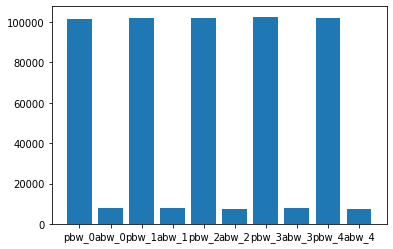

In [ ]:
import pandas as pd
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
import numpy as np
import matplotlib.pyplot as plt

train_modified = pd.read_csv('train_modified.csv')
train = pd.read_csv('Train.csv')
ids = []
pbw = []
abw = []


def append_labels(id):
    ids.append(id)
    id = id.split('.')[0]
    pbw.append(train_modified[train_modified['image_id'] == f"{id}_pbw.jpg"]['number_of_worms'].values[0])
    abw.append(train_modified[train_modified['image_id'] == f"{id}_abw.jpg"]['number_of_worms'].values[0])


list(map(append_labels, train['image_id_worm'].values))
train_kf = pd.DataFrame({'image_id': ids, 'pbw': pbw, 'abw': abw})


def make_fold():
    mskf = MultilabelStratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    train_kf['fold'] = -1
    num_bins = int(np.floor(1 + np.log2(len(train_kf))))
    print(num_bins)
    train_kf.loc[:, "bins_1"] = pd.cut(train_kf['pbw'], bins=num_bins, labels=False)
    train_kf.loc[:, "bins_2"] = pd.cut(train_kf['abw'], bins=num_bins, labels=False)
    print(train_kf.head())
    for fold, (train_idx, val_idx) in enumerate(mskf.split(X=train_kf, y=train_kf[['bins_1', 'bins_2']].values)):
        train_kf.loc[val_idx, 'fold'] = fold

    train_kf.drop('bins_1', axis=1, inplace=True)
    train_kf.drop('bins_2', axis=1, inplace=True)
    labels_len_dict = {}
    for i in range(5):
        labels_len_dict.update({f'pbw_{i}': train_kf[train_kf['fold'] != i]['pbw'].sum()})
        labels_len_dict.update({f'abw_{i}': train_kf[train_kf['fold'] != i]['abw'].sum()})
    plt.bar(labels_len_dict.keys(), labels_len_dict.values())
    plt.show()
    return train_kf


x = make_fold()
x.to_csv('train_mskf_5_fold.csv', index=False)


In [ ]:
import shutil
import os
import pandas as pd
from tqdm.auto import tqdm

train_kf = pd.read_csv('/content/train_mskf_5_fold.csv')
os.makedirs('/content/data',exist_ok=True)
for i in tqdm(range(5)):
    val_df = train_kf[train_kf['fold'] == i].reset_index(drop=True)
    os.makedirs('/content/data/dataset/fold_{}/images/'.format(i),
                exist_ok=True)
    os.makedirs('/content/data/dataset/fold_{}/labels/'.format(i), exist_ok=True)
    for j in tqdm(val_df['image_id'].unique()):
        shutil.copy(f'/content/train_images/{j}',
                    f'/content/data/dataset/fold_{i}/images')
        if os.path.exists(f'/content/labels/{j.split(".")[0]}.txt'):
            shutil.copy(f'/content/labels/{j.split(".")[0]}.txt',
                        f'/content/data/dataset/fold_{i}/labels')


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1962 [00:00<?, ?it/s]

  0%|          | 0/1956 [00:00<?, ?it/s]

  0%|          | 0/1962 [00:00<?, ?it/s]

  0%|          | 0/1960 [00:00<?, ?it/s]

  0%|          | 0/1952 [00:00<?, ?it/s]

In [ ]:
import yaml

folds = list(range(5))
for i in folds:
    train_path = []
    for j in range(5):
        if i != j:
            train_path.append(f'./dataset/fold_{j}/images/')

    data = dict(
        train=train_path,
        val=f'./dataset/fold_{i}/images/',
        names=['pbw', 'abw']
    )
    with open(f'/content/data/fold_{i}.yaml', 'w') as outfile:
        yaml.dump(data, outfile, default_flow_style=False)



In [ ]:
!zip -r data.zip data

Streaming output truncated to the last 5000 lines.
  adding: data/dataset/fold_0/images/id_15b7df33cedf60ce31131258.jpg (deflated 1%)
  adding: data/dataset/fold_0/images/id_b623be61fa85ff72c92f4fca.jpg (deflated 0%)
  adding: data/dataset/fold_0/images/id_e14890b784c3577428dc8f32.jpg (deflated 0%)
  adding: data/dataset/fold_0/images/id_72a70649c60434370903e561.jpg (deflated 0%)
  adding: data/dataset/fold_0/images/id_551c3a4c025e527553d356ce.jpg (deflated 1%)
  adding: data/dataset/fold_0/images/id_6b8fde488bc9a14959924763.jpg (deflated 1%)
  adding: data/dataset/fold_0/images/id_c8c502781602c15ae6a2d804.jpg (deflated 1%)
  adding: data/dataset/fold_0/images/id_e2b0cec1e4ed38e8ab038187.jpg (deflated 0%)
  adding: data/dataset/fold_0/images/id_56bcab5582c52adbbcb9bedb.jpg (deflated 1%)
  adding: data/dataset/fold_0/images/id_223bcd3c2208d3b1bd4c9fa9.jpg (deflated 0%)
  adding: data/dataset/fold_0/images/id_cd76185f95b84f78ff5467ac.jpg (deflated 0%)
  adding: data/dataset/fold_0/images

In [ ]:
!zip -r test_images /content/test_images

In [ ]:
!cp -r /content/test_images.zip /content/drive/MyDrive/data